In [2]:
# import zipfile
# with zipfile.ZipFile("dog-breed-identification.zip", 'r') as zip_ref:
#     zip_ref.extractall(".")

In [92]:
import pandas as pd
df = pd.read_csv('labels.csv')
df['id'] = df['id'].apply(lambda x: "train\\\\" + x + '.jpg')
df.head(5)

,id,breed
0,train\\000bec180eb18c7604dcecc8fe0dba07.jpg,boston_bull
1,train\\001513dfcb2ffafc82cccf4d8bbaba97.jpg,dingo
2,train\\001cdf01b096e06d78e9e5112d419397.jpg,pekinese
3,train\\00214f311d5d2247d5dfe4fe24b2303d.jpg,bluetick
4,train\\0021f9ceb3235effd7fcde7f7538ed62.jpg,golden_retriever


# 1. Импорт библиотек

In [72]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
from torchvision import datasets, models, transforms
from torch.utils.data import DataLoader, Dataset
import pandas as pd
from PIL import Image
import os
import numpy as np
from PIL import Image
from typing import Any

In [4]:
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
print("Device", device)


Device cuda


In [20]:


batch_size = 32
num_epochs = 25
learning_rate = 0.001
input_size = 224  # Для ResNet или других моделей pre-trained


In [51]:
# train_photo = os.listdir(r'C:\Data\Visual Studio\Задачи по машинному обучению(практика)\Dog Breed Identification\test')
# test_photo = os.listdir(r'C:\Data\Visual Studio\Задачи по машинному обучению(практика)\Dog Breed Identification\train')

# # train_df = df[df['id'] == terain_photo]
# # test_df = df[df['id'] == test_photo]


In [58]:
df.shape
# os.path.join(train_dir, df.iloc[4, 0] + '.jpg')

(10222, 2)

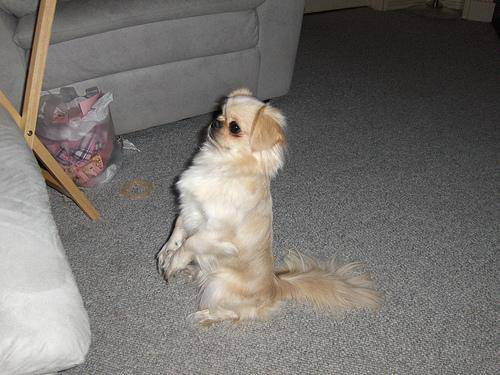

In [93]:
show_photo(df['id'][2])

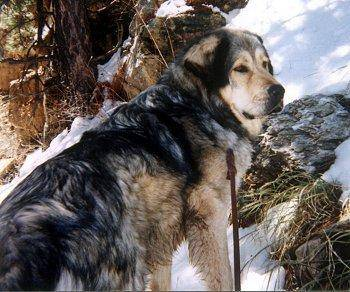

In [16]:
def show_photo(parh :str):
    return Image.open(parh)


show_photo(r'C:\Data\Visual Studio\Задачи по машинному обучению(практика)\Dog Breed Identification\test\ffe9717b7937c262f849416976f7620a.jpg')

# Создание дата сета 

In [144]:
FOTO_TRANSFORM = transforms.Compose([
    transforms.Resize((244, 244)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std = [0.229, 0.224, 0.225])
])

In [145]:
img = Image.open(df['id'][2])
FOTO_TRANSFORM(img).size()

torch.Size([3, 244, 244])

In [278]:
breed = df['breed'].unique()
labals = torch.tensor(range(0, 120))
dict_labels = dict(zip(breed, labals))
df['labels'] = df['breed'].apply(lambda x: dict_labels[x])
df.head()

,id,breed,labels
0,train\\000bec180eb18c7604dcecc8fe0dba07.jpg,boston_bull,tensor(0)
1,train\\001513dfcb2ffafc82cccf4d8bbaba97.jpg,dingo,tensor(1)
2,train\\001cdf01b096e06d78e9e5112d419397.jpg,pekinese,tensor(2)
3,train\\00214f311d5d2247d5dfe4fe24b2303d.jpg,bluetick,tensor(3)
4,train\\0021f9ceb3235effd7fcde7f7538ed62.jpg,golden_retriever,tensor(4)


In [286]:

class DogBreedDataset(Dataset):
    def __init__(self, dataframe, transform) -> None:
        super().__init__()
        self.dataframe = dataframe
        self.transform = transform

    def __len__(self):
        return len(self.dataframe)
    
    def __getitem__(self, index) -> Any:
        # Получаем путь к изображению для текущего индекса
        image_path = self.dataframe.iloc[index, 0]
        
        # Открываем изображение по этому пути
        image_open = Image.open(image_path)
        
        # Применяем трансформации
        trans_image = self.transform(image_open)
        
        # Получаем метку (породу собаки)
        label = self.dataframe.iloc[index, 2]

        # Возвращаем одно изображение и одну метку
        return trans_image, label



train_dataset = DogBreedDataset(dataframe=df, transform=FOTO_TRANSFORM)  
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)

# мОДЕЛЬ 


In [357]:
class CNN_model(nn.Module):
    def __init__(self, num_classes) -> None:
        super().__init__()
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3)
        self.conv2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=5)
        self.conv3 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3)
        self.conv4 = nn.Conv2d(in_channels=128, out_channels=64, kernel_size=3)

        self.pool_1 = nn.MaxPool2d(kernel_size=2, stride=1, padding=0)
        self.pool_2 = nn.MaxPool2d(kernel_size=2, stride=2, padding=0)
        self.relu = nn.ReLU()

        self.fc1 = nn.Linear(64 * 13 * 13, 1024)
        self.fc2 = nn.Linear(1024, 512)
        self.fc3 = nn.Linear(512, num_classes)
        
        self.softmax = nn.Softmax(dim=1)
        self.dropout = nn.Dropout(0.4)
    
    def forward(self, x):
        x = self.pool_2((self.conv1(x)))
        x = self.relu(x)
        x = self.pool_2((self.conv2(x)))
        x = self.relu(x)
        x = self.pool_2((self.conv3(x)))
        x = self.relu(x)
        x = self.pool_2((self.conv4(x)))
        x = self.relu(x)

        x = x.view(-1, 64 * 13 * 13)

        x = self.fc1(x)
        x = self.relu(x)
        x = self.dropout(x)

        x = self.fc2(x)
        x = self.relu(x)
        x = self.dropout(x)

        x = self.fc3(x)
        # x = self.softmax(x)
        # x = torch.argmax(x, dim=1)
        # x = x.long()

        return x


In [370]:
num_classes = len(df['breed'].unique())  # Количество пород
model = CNN_model(num_classes=num_classes)

# Перевод модели на GPU (если доступно)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)  # Перевод модели на GPU


optimizer =  optim.Adam(model.parameters(), lr=0.001)
# Определение функции ошибки Multi-Class Log Loss
criterion = nn.CrossEntropyLoss()

# Обучение

In [371]:
def calculate_accuracy(outputs, labels):
    _, predicted = torch.max(outputs, 1)  # Получаем индексы максимальных значений (предсказания)
    correct = (predicted == labels).sum().item()  # Сравниваем с истинными метками
    total = labels.size(0)  # Общее количество элементов в батче
    accuracy = correct / total  # Вычисляем точность
    return accuracy
calculate_accuracy(model(images), labels)

0.03125

In [372]:
num_epochs = 10

model.train()

for epoch in range(num_epochs):
    running_loss = 0.0
    running_accuracy = 0.0
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        # Обнуление градиентов
        optimizer.zero_grad()
        
        # Прямой проход
        outputs = model(images)
        loss = criterion(outputs, labels)

         # Обратное распространение
        loss.backward()
        
        # Шаг оптимизатора
        optimizer.step()
        
        running_loss += loss.item()

        # Вычисление точности
        accuracy = calculate_accuracy(outputs, labels)
        running_accuracy += accuracy
    
    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {running_loss/len(train_loader):.4f}, accuracy: {accuracy}')


Epoch [1/10], Loss: 4.7867, accuracy: 0.07142857142857142
Epoch [2/10], Loss: 4.7818, accuracy: 0.0
Epoch [3/10], Loss: 4.7802, accuracy: 0.0
Epoch [4/10], Loss: 4.7797, accuracy: 0.07142857142857142
Epoch [5/10], Loss: 4.7794, accuracy: 0.07142857142857142
Epoch [6/10], Loss: 4.7790, accuracy: 0.0
Epoch [7/10], Loss: 4.7789, accuracy: 0.0
Epoch [8/10], Loss: 4.7783, accuracy: 0.0
Epoch [9/10], Loss: 4.7782, accuracy: 0.0
Epoch [10/10], Loss: 4.7784, accuracy: 0.0


In [373]:
# Сохранение всей модели
torch.save(model, 'model_1_my.pth')

In [ ]:
# # Загрузка модели
# model = torch.load('model_1_my.pth')

# # Если у вас есть GPU, отправьте модель на устройство:
# model.to(device)
